In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from transformers import AutoTokenizer, GPT2LMHeadModel
from datasets import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline


torch.manual_seed(12046)
# Device: A100 40G
# If using a CPU, it will take a considerable amount of time. 
# Please consider reducing sequence_len, batch_size to speed up the process.

In [2]:
# Some parameters
learning_rate = 6e-4
# The max length of text that model supports
sequence_len = 512
batch_size = 16
gra_acc_steps = 8
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 4
eval_interval = 100

In [3]:
tokenizer = AutoTokenizer.from_pretrained('gpt2')
model = GPT2LMHeadModel.from_pretrained('gpt2').to(device)

In [4]:
raw_datasets = load_dataset('tatsu-lab/alpaca')
datasets = raw_datasets['train']
datasets[112], datasets[8]

({'instruction': 'Identify the incorrect word and suggest a better version.',
  'input': 'The waitress served a humonguous burger.',
  'output': 'The incorrect word is "humonguous" and it should be replaced with "huge".',
  'text': 'Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nIdentify the incorrect word and suggest a better version.\n\n### Input:\nThe waitress served a humonguous burger.\n\n### Response:\nThe incorrect word is "humonguous" and it should be replaced with "huge".'},
 {'instruction': 'Render a 3D model of a house',
  'input': '',
  'output': '<nooutput> This type of instruction cannot be fulfilled by a GPT model.',
  'text': 'Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRender a 3D model of a house\n\n### Response:\n<nooutput> This type of instruction cannot 

In [5]:
context_template = 'Below is an instruction that describes a task. ' + \
'Write a response that appropriately completes the request.\n\n' +\
'### Instruction:\n{instruction}\n\n### Response:\n'

def prepare_input(data):
    '''
    Use template to generate train text and then do tokenization.
    '''
    context = context_template.format_map(data)
    whole_text = context + data['output'] + tokenizer.eos_token
    ids = tokenizer.encode(whole_text)
    # Doing fine-tuning, we do NOT consider the text in template
    context_ids = tokenizer.encode(context)
    # -100 means that the model loss will ignore this position
    # More details can be found in the official document
    labels = [-100] * len(context_ids) + ids[len(context_ids):]
    return {'input_ids': ids, 'labels': labels}

# An example
re = prepare_input(datasets[8])
# Only the text after 'Response:\n' will be used in the computation of model loss
tokenizer.decode(re['input_ids']), tokenizer.decode(list(filter(lambda x: x != -100, re['labels'])))

('Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\nRender a 3D model of a house\n\n### Response:\n<nooutput> This type of instruction cannot be fulfilled by a GPT model.<|endoftext|>',
 '<nooutput> This type of instruction cannot be fulfilled by a GPT model.<|endoftext|>')

In [6]:
tokenized = datasets.train_test_split(test_size=0.1, seed=1024, shuffle=False)
tokenized = tokenized.map(prepare_input, remove_columns=datasets.column_names)
tokenized.set_format(type='torch', device=device)
# Concatenate all the data
train_set = {
    'input_ids': torch.concatenate(tokenized['train']['input_ids']),
    'labels': torch.concatenate(tokenized['train']['labels'])
}
test_set = {
    'input_ids': torch.concatenate(tokenized['test']['input_ids']),
    'labels': torch.concatenate(tokenized['test']['labels'])
}

train_set['input_ids'].shape, train_set['labels'].shape

Map:   0%|          | 0/46801 [00:00<?, ? examples/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1511 > 1024). Running this sequence through the model will result in indexing errors


Map:   0%|          | 0/5201 [00:00<?, ? examples/s]

(torch.Size([4707809]), torch.Size([4707809]))

In [7]:
def get_data(data, batch_size, sequence_len):
    '''
    Generate train data
    '''
    inputs = data['input_ids']
    labels = data['labels']
    # Generate the start of data, shape (B), B means batch_size
    ix = torch.randint(len(inputs) - sequence_len, (batch_size,))
    x = torch.stack([inputs[i: i + sequence_len] for i in ix])
    # We will use the implementation of transformers to compute model loss
    # It will do data shift inside the model, thus we will NOT shift y
    y = torch.stack([labels[i: i + sequence_len] for i in ix])
    return x, y

get_data(test_set, batch_size, sequence_len)

(tensor([[ 1499,   422, 39417,  ...,  4876,    13, 19430],
         [32543,   262,  2581,  ..., 12064,   326,  8477],
         [  198,   198, 21017,  ...,   262, 17118,     1],
         ...,
         [  257,  4876,    13,  ...,   257,  2882,   326],
         [  618,   262,  4403,  ...,   198,  9487,  1958],
         [  257,  4876,    13,  ..., 20277,   364,   477]], device='cuda:0'),
 tensor([[ 1499,   422, 39417,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ...,   262, 17118,     1],
         ...,
         [ -100,  -100,  -100,  ...,  -100,  -100,  -100],
         [  618,   262,  4403,  ...,  -100,  -100,  -100],
         [ -100,  -100,  -100,  ..., 20277,   364,   477]], device='cuda:0'))

In [8]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    trainable = f'trainable params: {trainable_params:,}'
    params = f'all params: {all_param:,}'
    percent = f'trainable%: {100 * trainable_params / all_param:.3f}'
    print(f'{trainable} || {params} || {percent}')

In [9]:
from peft import LoraConfig, PeftModel

def init_peft_model(model):
    # Initialize parameters of LoRA
    config = LoraConfig(
        r=4,
        lora_alpha=32,
        target_modules=['c_attn'],
        lora_dropout=0.1,
        # As the shape of c_attn.weight is (fan_in, fan_out), set this parameter to True
        # Note: for linear model, the shape of weight is (fan_out, fan_in)
        fan_in_fan_out=True,
        bias='none')
    return PeftModel(model, config, adapter_name='lora_alpaca')

print_trainable_parameters(model)
model = init_peft_model(model)
# Put the model on train mode
model.train()
print_trainable_parameters(model)

trainable params: 124,439,808 || all params: 124,439,808 || trainable%: 100.000
trainable params: 147,456 || all params: 124,587,264 || trainable%: 0.118


In [10]:
from contextlib import nullcontext

def estimate_loss(model, ctx=nullcontext()):
    '''
    Estimate the performance of model.
    Note: ctx is used for disabling LoRA or mixed precision.
    When ctx=nullcontext(), it have no effect.
    '''
    re = {}
    # Put the model on evaluation mode
    model.eval()
    _train = lambda: get_data(train_set, batch_size, sequence_len)
    re['train'] = _loss(model, _train, ctx)
    _test = lambda: get_data(test_set, batch_size, sequence_len)
    re['test'] = _loss(model, _test, ctx)
    # Put the model on train mode
    model.train()
    return re

@torch.no_grad()
def _loss(model, data_loader, ctx):
    """
    Measure the performance of model based on different data sets.
    """
    loss = []
    # Use eval_iters batch data to measure the performance
    for k in range(eval_iters):
        inputs, labels = data_loader()
        with ctx:
            # Use the method provided by transformers to compute model loss
            loss.append(model(input_ids=inputs, labels=labels).loss.item())
    return torch.tensor(loss).mean().item()

estimate_loss(model)

{'train': 2.9235620498657227, 'test': 2.8850600719451904}

In [11]:
# The code of get_lr is inspired by https://github.com/karpathy/nanoGPT/blob/master/train.py
import math

warmup_iters = 200
lr_decay_iters = 3000
min_lr = learning_rate / 10

def get_lr(it):
    '''
    Adjust learning rate dynamically 
    it means the step of training
    '''
    # 1. Linear warmup
    if it < warmup_iters:
        return learning_rate * it / warmup_iters
    # 2. If exceeding lr_decay_iters, return min_lr
    if it > lr_decay_iters:
        return min_lr
    # 3. decay learning rate
    decay_ratio = (it - warmup_iters) / (lr_decay_iters - warmup_iters)
    assert 0 <= decay_ratio <= 1
    coeff = 0.5 * (1.0 + math.cos(math.pi * decay_ratio))
    return min_lr + coeff * (learning_rate - min_lr)

In [12]:
# The parameter for gradient clipping
grad_clip = 1.0

def train_gpt_optimum(model, optimizer, data_loader, max_iters=1000):
    lossi = []
    scaler = torch.cuda.amp.GradScaler(enabled=(device == 'cuda'))
    for iter_num in range(max_iters):
        # Get learning rate
        lr = get_lr(iter_num + 1)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
        # Gradient accumulation
        for i in range(gra_acc_steps):
            inputs, labels = data_loader()
            # Mixed precision
            # If using a CPU, set dtype to torch.bfloat16
            ctx = torch.autocast(device_type=device, dtype=torch.float16)
            with ctx:
                loss = model(input_ids=inputs, labels=labels).loss
                lossi.append(loss.item())
                loss *= 1 / gra_acc_steps
            scaler.scale(loss).backward()
        # Gradient clipping
        scaler.unscale_(optimizer)
        clip_grad_norm_(model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        if iter_num % eval_interval == 0:
            # Measure the performance
            # We forget to use mixed precision here. It is a tiny bug
            stats = estimate_loss(model)
            train_loss = f'train loss {stats["train"]:.4f}'
            test_loss = f'test loss {stats["test"]:.4f}'
            print(f'step {iter_num:>4}: {train_loss}, {test_loss}')
    return lossi

In [13]:
data_loader = lambda: get_data(train_set, batch_size, sequence_len)
# Parameters for AdamW
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
optimizer = optim.AdamW(model.parameters(), lr=learning_rate,
                        betas=(beta1, beta2), weight_decay=weight_decay)
l = train_gpt_optimum(model, optimizer, data_loader, max_iters=2000)

step    0: train loss 2.8921, test loss 2.8898
step  100: train loss 2.4980, test loss 2.3948
step  200: train loss 2.3408, test loss 2.2779
step  300: train loss 2.2937, test loss 2.2836
step  400: train loss 2.2565, test loss 2.2617
step  500: train loss 2.2493, test loss 2.2790
step  600: train loss 2.2829, test loss 2.1847
step  700: train loss 2.2577, test loss 2.3036
step  800: train loss 2.2070, test loss 2.2426
step  900: train loss 2.2182, test loss 2.2067
step 1000: train loss 2.2719, test loss 2.2094
step 1100: train loss 2.3164, test loss 2.2448
step 1200: train loss 2.2444, test loss 2.2219
step 1300: train loss 2.2858, test loss 2.1962
step 1400: train loss 2.2495, test loss 2.1978
step 1500: train loss 2.2293, test loss 2.2963
step 1600: train loss 2.2280, test loss 2.2183
step 1700: train loss 2.3147, test loss 2.2030
step 1800: train loss 2.2065, test loss 2.2909
step 1900: train loss 2.1894, test loss 2.2781


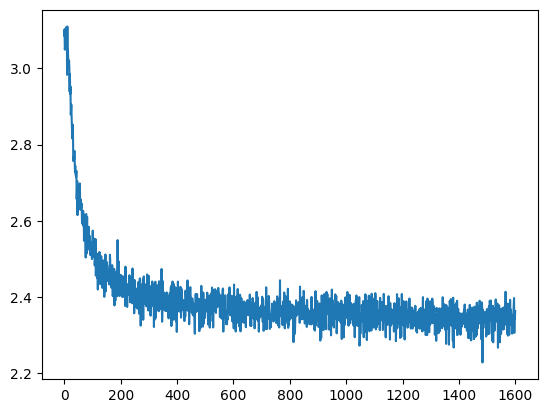

In [14]:
plt.plot(torch.tensor(l).view(-1, 10).mean(1).numpy())

In [19]:
def make_inference(model, question):
    context = context_template.format(instruction=question)
    token = tokenizer(context, return_tensors='pt').to(device)
    # Put the model on evaluation mode when doing text generation
    model.eval()
    output_tokens = model.generate(**token, max_new_tokens=100, early_stopping=True)
    model.train()
    print(tokenizer.decode(output_tokens[0], skip_special_tokens=True))

In [22]:
make_inference(model, 'Where is the capital of China?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Where is the capital of China?

### Response:
The capital of China is Beijing.


In [23]:
# Disable LoRA adapter to show the result before SFT
with model.disable_adapter():
    make_inference(model, 'Where is the capital of China?')

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Where is the capital of China?

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response:

The capital of China is the capital of China.

### Response
